<a href="https://colab.research.google.com/github/GuptaNavdeep1983/CS688/blob/main/767_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random


In [2]:
df = pd.read_csv("./Assignment_3_Hitters.csv")
df.rename( columns={'Unnamed: 0':'hitter_name'}, inplace=True )

df = pd.get_dummies(df, columns=['League', 'Division', 'NewLeague'], prefix=["League_is", "Division_is", "NewLeague"] )

X_train = df.loc[~df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]
y_train = df.loc[~df.isnull().any(axis=1), ['Salary']]
X_test = df.loc[df.isnull().any(axis=1), ~df.columns.isin(['Salary', 'hitter_name'])]


In [3]:
number_of_features = len(X_train.columns.values)
final_output = []

In [4]:
from enum import Enum
class Regularization(Enum):
     L2 = 1
     Lasso = 2
     No_regularization = 3

In [5]:
def predict(row, weights, bias):
  output = bias
  for index, weight in enumerate(weights):
    output += weight * row[index]
  return output if output > 0.0 else output * 0.05

def lasso_regularization(weights, lambda_val):
  return sum([abs(weight) for weight in weights]) * lambda_val
def l2_regularization(weights, lambda_val):
  return sum([weight**2 for weight in weights]) * (lambda_val/2)

def choose_regularzation(regularization, weights, lambda_val):
  if regularization == Regularization.L2:
    return l2_regularization(weights, lambda_val)
  elif regularization == Regularization.Lasso:
    return lasso_regularization(weights, lambda_val)
  else:
    return 0
def train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs, learning_rate, lambda_val, regularization_component, alpha_val=0.9, batch_size=12, ):
  # weights for all the features 
  weights = [random.uniform(-2,2)* math.sqrt(2/number_of_features) for i in range(number_of_features)]
  bias = 0
  index = 0
  plot_values = []
  while index < num_epochs:
    mse = 0.0
    total_weights = 0.0
    total_gradient = [0 for _ in range(number_of_features)]
    mini_batch = X_train.sample(n = batch_size, random_state=42)
    regularization = choose_regularzation(regularization_component, weights, lambda_val)
    for rowIndex, row in mini_batch.iterrows():
      predicted_value = predict(row, weights, bias)
      error = (y_train.loc[rowIndex,'Salary'] - predicted_value)
      error_with_regularization = error + regularization
      mse += error**2
      mse_with_regularization = mse + regularization
      total_gradient = [gradient + (error_with_regularization * row[gradient_index]) for gradient_index, gradient in enumerate(total_gradient)] 
    total_gradient = [(alpha_val * gradient) + gradient for gradient in total_gradient] 
    bias = bias + learning_rate * (mse_with_regularization/mini_batch.shape[0])
    weights = [weight + learning_rate * (total_gradient[weight_index]/mini_batch.shape[0]) for weight_index, weight in enumerate(weights)]
    index = index + 1
    plot_values.append((index, mse_with_regularization/mini_batch.shape[0]))
    # print('>epoch=%d, lrate=%.3f, error=%.3f' % (index, learning_rate, mse_with_regularization/mini_batch.shape[0]))
  df_plot_values = pd.DataFrame(plot_values, columns=['epoch', 'MSE'])
  return weights, bias, df_plot_values

#Learning Rate

To choose the learning rate, 

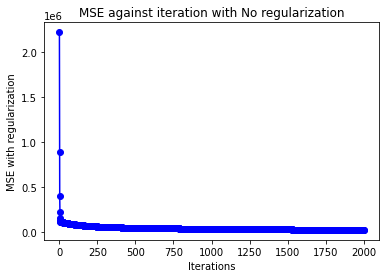

In [6]:
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=0.01, regularization_component=Regularization.No_regularization)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with No regularization")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("No_regularization", *weights))

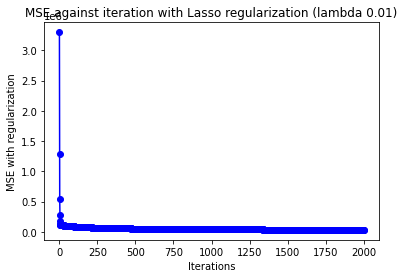

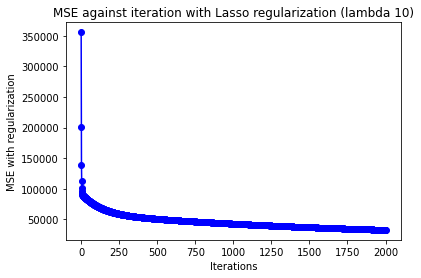

In [7]:
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=0.01, regularization_component=Regularization.Lasso)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with Lasso regularization (lambda 0.01)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("Lasso_regularization_with_lambda_0.01", *weights))
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=10, regularization_component=Regularization.Lasso)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with Lasso regularization (lambda 10)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("Lasso_regularization_with_lambda_10", *weights))

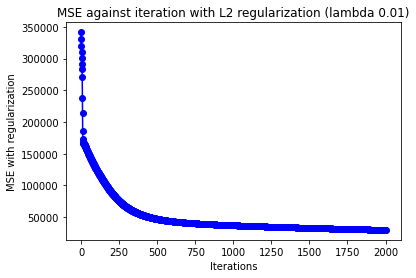

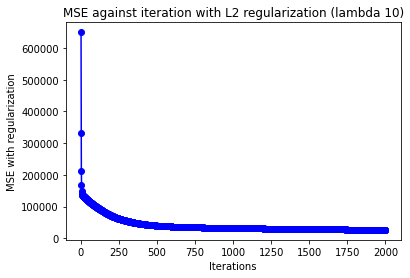

In [8]:
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=0.01, regularization_component=Regularization.L2)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with L2 regularization (lambda 0.01)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("L2_regularization_with_lambda_0.01", *weights))
(weights, bias, df_plot_values) = train_weights_using_batch_gradient_descent(X_train, y_train, num_epochs=2000, learning_rate=0.00000001, lambda_val=10, regularization_component=Regularization.L2)
plt.plot(df_plot_values['epoch'], df_plot_values['MSE'], marker='o', color='blue')
plt.title("MSE against iteration with L2 regularization (lambda 10)")
plt.xlabel("Iterations")
plt.ylabel("MSE with regularization")
plt.show()
final_output.append(("L2_regularization_with_lambda_10", *weights))

In [9]:
df_output = pd.DataFrame(final_output, columns=["Regularization", *X_train.columns.values])

df_output

,Regularization,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_is_A,League_is_N,Division_is_E,Division_is_W,NewLeague_A,NewLeague_N
0,No_regularization,0.390250,0.214528,0.568184,0.305595,0.010240,-0.206118,-0.276966,0.017626,0.285083,-0.338106,-0.266273,-0.126028,0.180565,0.272987,-0.063958,-0.045532,-0.083125,0.156283,0.143324,-0.231335,-0.570167,-0.001384
1,Lasso_regularization_with_lambda_0.01,0.241844,-0.404993,0.208728,-0.249900,-0.183130,-0.328507,-0.244332,0.176944,-0.212873,0.089696,0.077416,-0.167914,-0.284453,0.155785,0.559877,-0.425261,0.542868,-0.097495,0.495547,-0.539846,-0.563546,0.123231
2,Lasso_regularization_with_lambda_10,-0.000482,0.081434,0.483730,0.357202,0.492549,-0.507388,-0.034579,0.174752,-0.024274,0.004825,-0.302491,-0.225907,-0.177805,0.371901,0.529656,-0.373432,0.496611,0.427098,-0.368822,0.268862,-0.459543,0.091985
3,L2_regularization_with_lambda_0.01,0.258186,-0.209323,0.562637,-0.231431,0.149843,0.264473,-0.366433,0.037627,0.055796,0.270103,0.310441,-0.197822,-0.063602,0.125296,0.355860,-0.060391,-0.526241,-0.399940,0.090934,0.205936,-0.302434,0.148021
4,L2_regularization_with_lambda_10,0.211437,-0.177649,0.044697,0.273339,-0.013868,-0.081832,-0.340912,0.172433,-0.175199,0.330725,0.230636,-0.529644,-0.147643,0.001160,0.388441,-0.424002,0.441236,0.098279,0.271812,-0.333374,0.283166,-0.279962
